In [132]:
# import sys
# !{sys.executable} -m pip install PyYAML


In [133]:
# !pip install japanize-matplotlib
import os
import sys
import yaml
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification                         
import japanize_matplotlib #日本語表示対応


# Notebook から src ディレクトリを追加
sys.path.append(os.path.join(os.getcwd(), "src"))

# これで src/preprocess/make_tag_features.py が import 可能
from preprocess.make_tag_features import create_tag_features, extract_unique_tags

In [134]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=pd.errors.PerformanceWarning
)

## 01.config読み込み

In [135]:
conf_path = os.path.join( '../config/config.yaml')
with open(conf_path, 'r') as f:
    config = yaml.safe_load(f)

In [136]:
# 定義した特徴量リストを読み込み
feature_list = config['FEATURE']['FEATURE_LIST']

In [137]:
# カテゴリカルカラムのリストを定義
categorical_cols = config['FEATURE']['CATEGORICAL_COLS']

## 02.データ読み込み

In [138]:
# ドライブ内のファイルパスを指定
train_path = '../20.Data/train.csv'
df_train = pd.read_csv(train_path)

/tmp/ipykernel_14831/1821816592.py:3: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


In [139]:
# testデータの読み込み
test_path = '../20.Data/test.csv'
df_test = pd.read_csv(test_path)

df_test["renovation_date"] = pd.to_datetime(df_test["renovation_date"])
df_test["renovation_date"] = df_test["renovation_date"].astype("int64") // 10**9

/tmp/ipykernel_14831/1294476357.py:3: DtypeWarning: Columns (46,55,56,63,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(test_path)


## 03.前処理

In [140]:

# df_trainのカテゴリカルカラムを'category'型に変換
for col in categorical_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].astype('category')

In [141]:
# df_testのカテゴリカルカラムを'category'型に変換
for col in categorical_cols:
    if col in df_test.columns:
        df_test[col] = df_test[col].astype('category')

In [142]:
# 極端に高い売買価格はクリッピング
lower = df_train["money_room"].quantile(0.01)
upper = df_train["money_room"].quantile(0.99)

df_train["money_room"] = df_train["money_room"].clip(lower, upper)


In [143]:
# 極端な値はクリッピング
for col in feature_list:
    # 数値型でなければスキップ
    if not pd.api.types.is_numeric_dtype(df_train[col]):
        continue

    # 全部NaNの列はスキップ
    if df_train[col].notna().sum() == 0:
        continue

    # 1% / 99% パーセンタイル
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)

    # パーセンタイルが計算できない場合はスキップ
    if pd.isna(lower) or pd.isna(upper):
        continue

    # クリッピング
    df_train[col] = df_train[col].clip(lower, upper)


In [144]:
df_train["land_youto"] = df_train["land_youto"].where(
    df_train["land_youto"].isin([8, 14]),
    np.nan
).astype("category")

df_test["land_youto"] = df_test["land_youto"].where(
    df_test["land_youto"].isin([8, 14]),
    np.nan
).astype("category")


In [145]:
df_train["building_type"] = (
    df_train["building_type"]
    .where(df_train["building_type"].isin([1, 3]), np.nan)
)

df_test["building_type"] = (
    df_test["building_type"]
    .where(df_test["building_type"].isin([1, 3]), np.nan)
)


In [146]:
# 欠損値はカラムの型に応じて補完
for col in df_train.columns:
    if col == "money_room": # 目的変数はこの時点では補完しない
        continue

    # if col in categorical_cols: # 明示的に定義されたカテゴリカルカラム
    #     # LightGBMが0をカテゴリとして扱えるため、0で補完
    #     df_train[col] = df_train[col].fillna(0)
    elif df_train[col].dtype in ['int64', 'float64']: # 数値カラム
        # 数値カラムは訓練データの中央値で補完
        median_val = df_train[col].median()
        df_train[col] = df_train[col].fillna(median_val)
        df_test[col] = df_test[col].fillna(median_val)
    # else:
        # # その他の型（objectなど）は、とりあえず0で補完（必要に応じて調整）
        # df_train[col] = df_train[col].fillna(0)


/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/M

In [147]:
# # room_count
# # unit_area
df_train = df_train[(df_train["unit_area"]>12.5) & (df_train["unit_area"]<300)]

##### 日付関係のデータは経過日数を特徴量とする

In [148]:
# 'target_ym'をdatetime型に変換 (月の最初の日と仮定)
df_train['target_date'] = pd.to_datetime(df_train['target_ym'].astype(str) + '01', format='%Y%m%d')
df_test['target_date'] = pd.to_datetime(df_test['target_ym'].astype(str) + '01', format='%Y%m%d')

# 'building_create_date'をdatetime型に変換
df_train['building_create_date'] = pd.to_datetime(df_train['building_create_date'])
df_test['building_create_date'] = pd.to_datetime(df_test['building_create_date'])
# 築年数を計算 (年単位)
df_train['building_age'] = (df_train['target_date'] - df_train['building_create_date']).dt.days // 365
df_test['building_age'] = (df_test['target_date'] - df_test['building_create_date']).dt.days // 365

# 'renovation_date'がUNIXタイムスタンプになっているため、再度datetimeに変換して経過年数を計算
# 既に'renovation_date'はUNIXタイムスタンプに変換済みのため、元の日付情報に戻すか、元のカラムを使用する
# ここでは、元のカラムが保持されていると仮定し、新しいカラムとして計算
# 注: もしdf_train['renovation_date']がUNIXタイムスタンプのみになっている場合、この処理は調整が必要です。
# 既存のrenovation_date（UNIXタイムスタンプ）を無視し、元の文字列カラムが存在しないため、新たに変換する
# もし元の文字列カラムが失われている場合は、UNIXタイムスタンプをdatetimeに変換する
# 現状のNotebookの処理から判断すると、renovation_dateはUNIXタイムスタンプなので、それを基に経過年数を計算します。

# UNIXタイムスタンプからdatetimeへの変換
df_train['renovation_datetime'] = pd.to_datetime(df_train['renovation_date'], errors='coerce')
df_test['renovation_datetime'] = pd.to_datetime(df_test['renovation_date'], errors='coerce')

# リノベーションからの経過年数を計算 (年単位)
# リノベーション日がない場合はNaNとなり、NaNとtarget_dateの差もNaNになるため、後でfillnaで処理
df_train['years_since_renovation'] = (df_train['target_date'] - df_train['renovation_datetime']).dt.days // 365
df_test['years_since_renovation'] = (df_test['target_date'] - df_test['renovation_datetime']).dt.days // 365
# 欠損値の補完
# building_ageとyears_since_renovationの負の値（未来の日付）やNaNを処理
# 例: 負の値やNaNを0で補完する
df_train['building_age'] = df_train['building_age'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
df_test['building_age'] = df_test['building_age'].apply(lambda x: max(0, x) if pd.notna(x) else 0)

df_train['years_since_renovation'] = df_train['years_since_renovation'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
df_test['years_since_renovation'] = df_test['years_since_renovation'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
# 新しい特徴量をfeature_listに追加
new_features = ['building_age', 'years_since_renovation']
feature_list.extend(new_features)

# feature_listから'target_date', 'building_create_date', 'renovation_datetime'を削除 (直接特徴量として使わないため)
# (元のbuilding_create_dateとrenovation_dateはUNIX timestampとして残しておく)
feature_list = [f for f in feature_list if f not in ['target_date', 'building_create_date', 'renovation_date', 'renovation_datetime']]

# 確認
# print(df_train[feature_list].head())



## 04.特徴量生成

In [149]:
# タグIDの分割により特徴量を追加

# all_unique_tags という空の set を初期化
all_unique_tags = set()
# df_train の 'statuses' カラムに対して extract_unique_tags を呼び出し、得られたユニークタグを追加
all_unique_tags.update(extract_unique_tags(df_train, 'statuses'))
# df_test の 'statuses' カラムに対して extract_unique_tags を呼び出し、得られたユニークタグを追加
all_unique_tags.update(extract_unique_tags(df_test, 'statuses'))
# all_unique_tags をソートしてリストに変換し、all_unique_tags_list に格納
all_unique_tags_list = sorted(list(all_unique_tags))

# create_tag_features 関数を df_train と df_test に適用
df_train, new_tag_features = create_tag_features(df_train.copy(), all_unique_tags_list)
df_test, _ = create_tag_features(df_test.copy(), all_unique_tags_list)
# 既存の feature_list に new_tag_features を追加
feature_list.extend(new_tag_features)

In [150]:
# LightGBM 用に使用するカテゴリ特徴量のリストを作成
categorical_features = [
    col for col in categorical_cols
    if col in feature_list
]

feature_list = feature_list.copy()

## 05.train/valid 分割　＆　target加工

In [ ]:
# X_all, X_train, X_validの再構築
X_all = df_train[feature_list]
y_all = df_train["money_room"]

# log変換前の元価格を保存（後段の重み付け用）
y_price_raw = df_train.loc[X_all.index, "money_room"]


# 目的変数が右に裾野が広いので対数変換
y_all = np.log1p(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


## 06.sample_weight適用

In [152]:
# 元スケールの価格
y_price = y_all


# train / valid に合わせる
y_price_raw_train = y_price_raw.loc[X_train.index]

# 低価格ほど重く（価格の逆数）
sample_weight = 1 / np.log1p(np.maximum(y_price_raw_train, 1_000_000))

# 正規化
sample_weight = sample_weight / sample_weight.mean()

## 07.モデル学習

In [153]:
# カスタム評価関数（eval_metric形式）
def mape_eval(preds, train_data):
    y_true = np.expm1(train_data.get_label())
    y_pred = np.expm1(preds)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100
    return 'mape', mape, False


In [154]:
# LightGBM のパラメータ設定
params = config['MODEL_PARAMS']

# LightGBM のデータセットを作成
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    weight=sample_weight.loc[X_train.index],
    categorical_feature=categorical_features
)

lgb_test = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,
    categorical_feature=categorical_features
)


特徴量の重要度


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

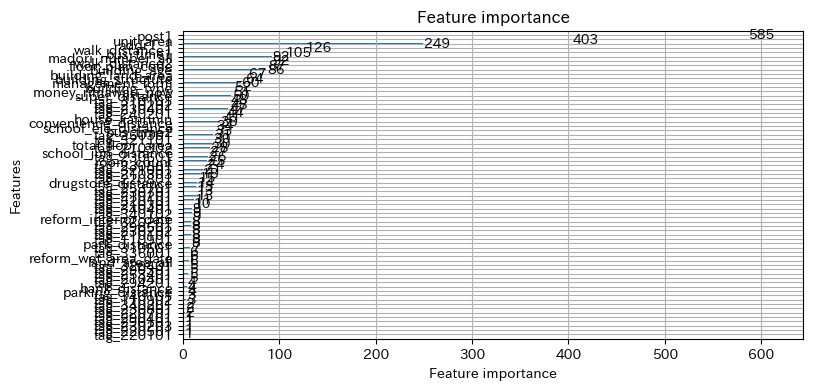

In [ ]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  feval=mape_eval,  # ← カスタム評価関数を指定
                  callbacks=[lgb.early_stopping(stopping_rounds=1000, verbose=False)
                  ]) #early_stoppingあり


## 08.評価

In [ ]:
# テストデータで予測
y_pred = model.predict(X_valid , num_iteration=model.best_iteration)

# 対数変換を戻す
y_pred = np.expm1(y_pred)
y_valid = np.expm1(y_valid)

# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_pred = np.where(y_pred < 6000000, y_pred * 1.5, y_pred)
# y_valid = np.where(y_valid < 6000000, y_valid * 1.5, y_valid)


yp = pd.DataFrame(y_pred,columns=["%"])




# 特徴量の重要度
print("特徴量の重要度")
lgb.plot_importance(model, figsize=(8,4))


## 09.可視化（importance SHAP）

In [ ]:

# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

# # パラメータの探索範囲を指定
# param_grid = {
#     'num_leaves': [20, 30, 40],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [5, 10]
# }




# # グリッドサーチCV
# gsearch = GridSearchCV(gbm, param_grid, cv=5) #cvは交差検証の回数

# # データを学習
# gsearch.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])



# # 最適なパラメータとスコアを表示
# print('Best parameters found by grid search are:', gsearch.best_params_)
# print('Best score:', gsearch.best_score_)


In [157]:
# # パラメータの辞書を結合
# best_params = {**params, **gsearch.best_params_}

# # 最適パラメータでモデルを再学習
# model = lgb.LGBMClassifier(**best_params)
# model.fit(X_train, y_train)

In [ ]:
#SHAP値の取得
explainer = shap.TreeExplainer(model=model)#SHAP値を取得するためのモデル作成
shap_values = explainer.shap_values(X=X_valid)#説明変数それぞれの値のSHAP値を取得する

# print(shap_values)
# print(shap_values.shape)


[[-0.00130629  0.          0.00921276 ...  0.         -0.0028223
   0.        ]
 [-0.00298108  0.         -0.00872533 ...  0.         -0.00068002
   0.        ]
 [-0.01309812  0.          0.04519438 ...  0.         -0.00116825
   0.        ]
 ...
 [ 0.00436244  0.          0.02067653 ...  0.         -0.00299213
   0.        ]
 [-0.00175574  0.         -0.01131975 ...  0.         -0.0012155
   0.        ]
 [-0.00157763  0.          0.0114607  ...  0.         -0.00209707
   0.        ]]
(72785, 186)


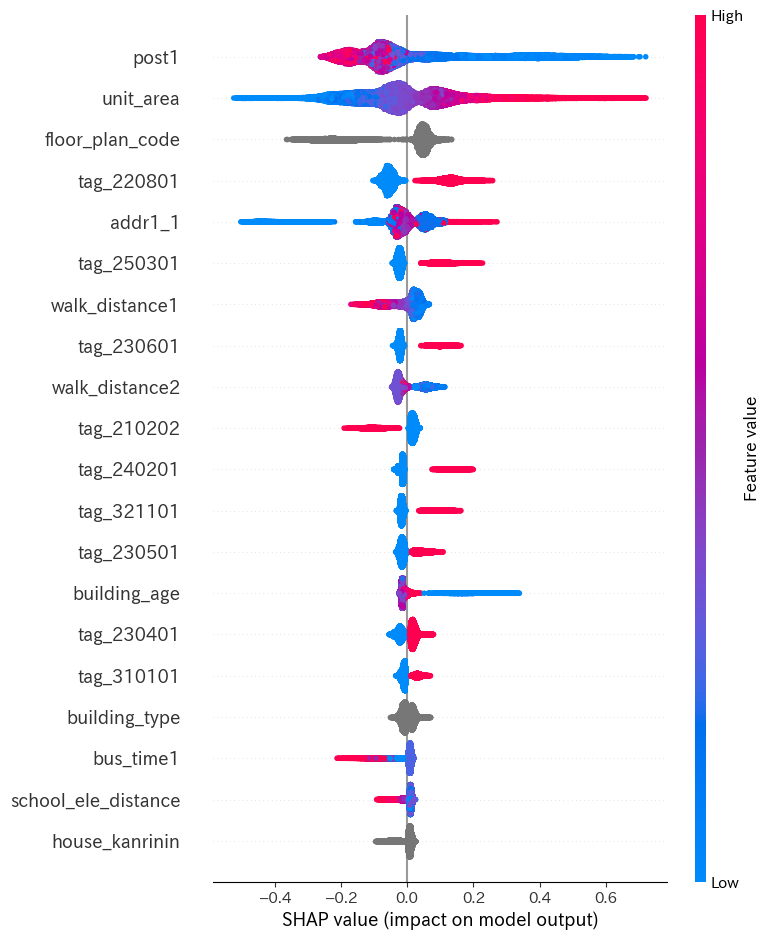

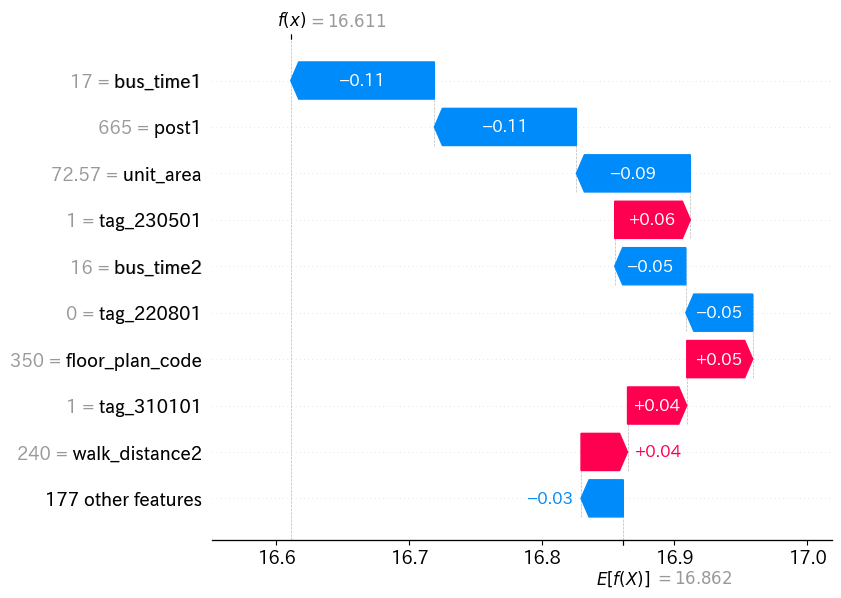

In [159]:

# 変数別の影響度の可視化
shap.initjs()
shap.summary_plot(shap_values, X_valid)

# 0番目のデータポイントを再選択
i = 0
single_observation = X_valid.iloc[i:i+1,:]

#print(single_observation)


# Explainerを使って説明を再計算
single_shap_values = explainer(single_observation)

# waterfallプロットの生成
shap.waterfall_plot(single_shap_values[0])

## 10.推論、提出

## 提出用データの作成

In [160]:
# 特徴量の選定
df_test_p = df_test[feature_list]


# 提出データに対する予測（確率値）
y_scores_submit = model.predict(df_test_p)
# # y_scores_binary_submit = np.where(y_scores_submit>0.5, 1, 0)


y_scores_submit= np.expm1(y_scores_submit)

# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_scores_submit = np.where(y_scores_submit < 6000000, y_scores_submit * 1.5, y_scores_submit)


print(y_scores_submit)

# y_scores_survive_submit = y_scores_submit[:, 1]

[16067725.30134794 27705776.65661428 20112007.43888131 ...
 14461610.4668441  17343071.71964744 16853612.96849792]


In [161]:



#提出用csvの作成
df_scores_submit = pd.DataFrame(y_scores_submit)

# df_submit = pd.concat([df_test["id"], df_scores_submit], axis=1)
# df_scores_submit.index = df_scores_submit.index + 1
df_scores_submit.to_csv("submit.csv", index=True, header=False)




In [ ]:
# テストデータに対する予測（確率値）？？？？？？？？？？？？？？？？？？？？？？？・
y_scores = model.predict(X_valid)
# y_scores

## 誤差要因分析

<Axes: ylabel='Frequency'>

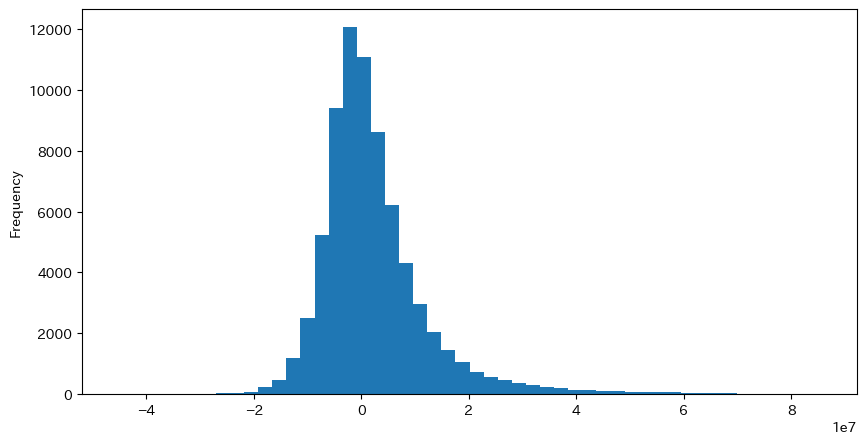

In [163]:
# valid予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)
# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_pred_valid = np.where(y_pred_valid < 6000000, y_pred_valid * 1.5, y_pred_valid)





df_eval = X_valid.copy()
df_eval["y_true"] = y_valid
df_eval["y_pred"] = y_pred_valid

# APE計算（0割防止）
df_eval["ape"] = np.abs(df_eval["y_true"] - df_eval["y_pred"]) / np.maximum(df_eval["y_true"], 1e-7)

# 上位ワースト確認
# df_eval.sort_values("ape", ascending=False).head(20)
df_eval["スコア差分"] = df_eval["y_true"] - df_eval["y_pred"]
df_eval["スコア差分"].plot.hist(bins=50, figsize=(10,5))

In [164]:
# 価格帯ビン作成
df_eval["price_bin"] = pd.qcut(df_eval["y_true"], q=5)

# 価格帯別MAPE
mape_by_bin = df_eval.groupby("price_bin")["ape"].mean() * 100
print("価格帯別のMAPE\n", mape_by_bin)
print()
print("全データのMAPE", df_eval["ape"].mean())
print()


価格帯別のMAPE
 price_bin
(5399999.999, 12800000.0]    55.779203
(12800000.0, 18600000.0]     22.867023
(18600000.0, 25000000.0]     20.008374
(25000000.0, 35000000.0]     20.419367
(35000000.0, 99500000.0]     27.592850
Name: ape, dtype: float64

全データのMAPE 0.2958436867890533



/tmp/ipykernel_14831/65498744.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_bin = df_eval.groupby("price_bin")["ape"].mean() * 100


In [165]:
def compare_distribution(col):
    return pd.DataFrame({
        "train": df_train[col].describe(),
        "valid": X_valid[col].describe()
    })

compare_distribution("money_rimawari_now")


,train,valid
count,363924.000000,72785.000000
mean,5.767516,5.768294
std,0.337657,0.327940
min,0.000000,0.000000
25%,5.760000,5.760000
50%,5.760000,5.760000
75%,5.760000,5.760000
max,12.890300,12.890300


In [166]:
# APEが大きい上位10%
threshold = df_eval["ape"].quantile(0.9)
bad_samples = df_eval[df_eval["ape"] >= threshold]

# SHAP値抽出
shap_values_valid = explainer.shap_values(X_valid)
shap_df = pd.DataFrame(
    shap_values_valid,
    columns=X_valid.columns,
    index=X_valid.index
)


# 悪いサンプルのSHAP平均
shap_df.loc[bad_samples.index].abs().mean().sort_values(ascending=False).head(10)


unit_area          0.128998
post1              0.127753
floor_plan_code    0.082518
tag_220801         0.067547
addr1_1            0.050006
tag_250301         0.035448
walk_distance1     0.034609
tag_210202         0.033362
walk_distance2     0.033142
tag_230601         0.028054
dtype: float64

In [167]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_train)

In [168]:
def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100


# valid 予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)
# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_pred_valid = np.where(y_pred_valid < 6000000, y_pred_valid * 1.5, y_pred_valid)

# MAPE 出力
valid_mape = calc_mape(y_valid, y_pred_valid)
print(f"VALID MAPE: {valid_mape:.4f}%")


VALID MAPE: 29.5844%
